In [52]:
%matplotlib inline
import pickle
import gym
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [15]:
with open('./expert_data/Hopper-v1.pkl', 'rb') as f:
    expert_data = pickle.load(f)

In [16]:
hopper = gym.make('Hopper-v1')
hopper.action_space, hopper.observation_space

[2018-05-29 18:46:33,127] Making new env: Hopper-v1


(Box(3,), Box(11,))

In [59]:
obs = th.from_numpy(np.array(expert_data['observations'])).float()
act = th.from_numpy(np.array(expert_data['actions'])).squeeze(1).float()

In [97]:
dataset = TensorDataset(obs, act)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True, num_workers=10)

In [98]:
class Imitate(nn.Module):
    def __init__(self):
        super(Imitate, self).__init__()
        width = 100
        self.lin1 = nn.Linear(11, width)
        self.lin2 = nn.Linear(width, width)
        self.lin3 = nn.Linear(width, width)
        self.lin4 = nn.Linear(width, 3)        

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        return self.lin4(x)

In [104]:
model = Imitate()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [105]:
def train():
    model.train()
    for X, y in dataloader:
        optimizer.zero_grad()
        output = model(X)
        loss = F.mse_loss(output, y)
        loss.backward()
        optimizer.step()
        return loss.item()

In [106]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            output = model(X)
            test_loss += F.mse_loss(output, y, size_average=False).item() # sum up batch loss
        test_loss /= len(dataloader.dataset)
        print('Test set: Average loss: {:.4f}'.format(test_loss))
        return test_loss

In [109]:
training_loss = []
test_loss = []
for epoch in range(1, 101):
    training_loss.append(train())
    test_loss.append(test())

Test set: Average loss: 0.9343
Test set: Average loss: 0.9147
Test set: Average loss: 0.8003
Test set: Average loss: 0.6997
Test set: Average loss: 0.7171
Test set: Average loss: 0.6182
Test set: Average loss: 0.6042
Test set: Average loss: 0.5316
Test set: Average loss: 0.4540
Test set: Average loss: 0.5434


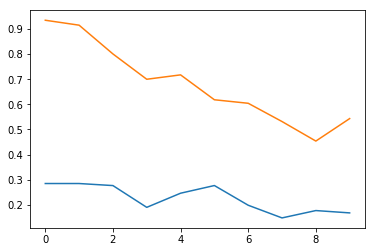

In [110]:
plt.plot(range(len(training_loss)), list(zip(training_loss, test_loss)))